# Introduction

## Instructions
---
The UCI Center for Machine Learning and Intelligent Systems hosts a dataset that is relevant to what might be seen at Measurabl. It can be downloaded here: [UCI Machine Learning Repository: Individual household electric power consumption Data Set](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)

* When you go to the link provided, you need to click the "Data Folder" at the top left, then download the household_power_consumption.zip file, which contains the only file needed for the data challenge. 
* Please review the dataset and present one or more interesting facts about this dataset. Any data exploration should be written in Python as part of a Jupyter notebook. Another party should be able to reproduce your results provided the Jupyter notebook and raw data. 
* This project is intentionally left open-ended,  please feel free to reach out to me with any questions that you may have. 

## Approach
---
Given that this was an open-ended project, the motivation I created was that the household was providing this dataset in order to:
1. Gain insight into how energy is being consumed, in order to help guide new energy reduction policies
2. Forecast future energy consumption, in order to help determine if the household's energy consumption targets will be met

The approach I took was: 
1. `Create Clean Dataset`: Create dataset useful for this project
2. `Analyze Clean Dataset`: Produce visualizations and notes useful for downstream analyses
3. `Insights`: Produce visualizations and insights useful to present to the household to help guide new energy reduction policies
4. `Forecast`: Create a time-series forecasting model, and utilize it to forecast out energy usage for the household

# Setup

In [30]:
import datetime as dt
import json
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.serialize import model_to_json, model_from_json

# Display
sns.set(style="whitegrid")
sns.set_context(context="paper")

# Read Source Dataset

Source Dataset Columns:
* global_active_power: The total active power consumed by the household (kilowatts).
* global_reactive_power: The total reactive power consumed by the household (kilowatts).
* voltage: Average voltage (volts).
* global_intensity: Average current intensity (amps).
* sub_metering_1: Active energy for kitchen (dishwasher, oven, microwave) (watt-hours of active energy).
* sub_metering_2: Active energy for laundry room (washing-machine, drier, refrigerator, and light) (watt-hours of active energy).
* sub_metering_3: Active energy for climate control systems (water-heater and air-conditioner) (watt-hours of active energy).
* adding a some notes

In [4]:
df_source = pd.read_csv(
    './data/household_power_consumption.txt', 
    sep=';', 
    low_memory=False,
    infer_datetime_format=True, 
    parse_dates={'time': [0, 1]})

In [6]:
df_source.info()
display(df_source.head(3))
display(df_source.tail(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   time                   datetime64[ns]
 1   Global_active_power    object        
 2   Global_reactive_power  object        
 3   Voltage                object        
 4   Global_intensity       object        
 5   Sub_metering_1         object        
 6   Sub_metering_2         object        
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 126.7+ MB


,time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


,time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075256,2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0
2075257,2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0
2075258,2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0


# Create Clean Dataset

In [14]:
def transform_missing_values(df):
    return df.replace('?', np.nan)


def convert_dtypes(df):
    return df.astype({
        'Global_active_power': float,
        'Global_reactive_power': float,
        'Global_intensity': float,
        'Voltage': float,
        'Sub_metering_1': float,
        'Sub_metering_2': float,
        'Sub_metering_3': float})


def create_Global_active_power_wh(df):
    """Create global active power in watt-hour units"""
    return df.assign(Global_active_power_wh=df.Global_active_power * 1000 / 60)


def create_sub_metering_remainder(df):
    return df.assign(Sub_metering_remainder=
        df.Global_active_power_wh - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3))


def format_dataset(df):
    df = df.rename(columns={
        'Sub_metering_1': 'Sub_metering_1_kitchen',
        'Sub_metering_2': 'Sub_metering_2_laundry',
        'Sub_metering_3': 'Sub_metering_3_climate'})
    
    return df.drop([
        'Global_active_power',  # perfectly correlated with Global_active_power_kwh
        'Global_intensity'      # perfectly correlated with Global_active_power_kwh
    ], axis=1)


def sample_dataset(df):
    return df.sample(frac=0.75)

In [15]:
df_clean = (df_source
    # Order matters
    .pipe(transform_missing_values)
    .pipe(convert_dtypes)
    .pipe(create_Global_active_power_wh)
    .pipe(create_sub_metering_remainder)
    .pipe(format_dataset)
    .pipe(sample_dataset))

df_clean.to_parquet('./data/clean.parquet')

In [16]:
# (optional) Read dataset
df_clean = pd.read_parquet('./data/clean.parquet')

In [17]:
df_clean.info()
display(df_clean.head(2))
display(df_clean.tail(2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1556444 entries, 1052087 to 735683
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   time                    1556444 non-null  datetime64[ns]
 1   Global_reactive_power   1536990 non-null  float64       
 2   Voltage                 1536990 non-null  float64       
 3   Sub_metering_1_kitchen  1536990 non-null  float64       
 4   Sub_metering_2_laundry  1536990 non-null  float64       
 5   Sub_metering_3_climate  1536990 non-null  float64       
 6   Global_active_power_wh  1536990 non-null  float64       
 7   Sub_metering_remainder  1536990 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 106.9 MB


,time,Global_reactive_power,Voltage,Sub_metering_1_kitchen,Sub_metering_2_laundry,Sub_metering_3_climate,Global_active_power_wh,Sub_metering_remainder
1052087,2008-12-16 08:11:00,0.046,243.46,0.0,0.0,18.0,28.533333,10.533333
489803,2007-11-21 20:47:00,0.162,240.16,38.0,1.0,17.0,80.800000,24.800000


,time,Global_reactive_power,Voltage,Sub_metering_1_kitchen,Sub_metering_2_laundry,Sub_metering_3_climate,Global_active_power_wh,Sub_metering_remainder
106470,2007-02-28 15:54:00,0.132,243.09,0.0,0.0,0.0,5.533333,5.533333
735683,2008-05-10 14:47:00,0.228,242.61,0.0,0.0,1.0,8.266667,7.266667


# Analyze Clean Dataset

## Missing Values

In [31]:
null_ratios = df_clean.isnull().sum() / df_clean.shape[0]
null_ratios[null_ratios > 0]

Global_reactive_power     0.012499
Voltage                   0.012499
Sub_metering_1_kitchen    0.012499
Sub_metering_2_laundry    0.012499
Sub_metering_3_climate    0.012499
Global_active_power_wh    0.012499
Sub_metering_remainder    0.012499
dtype: float64

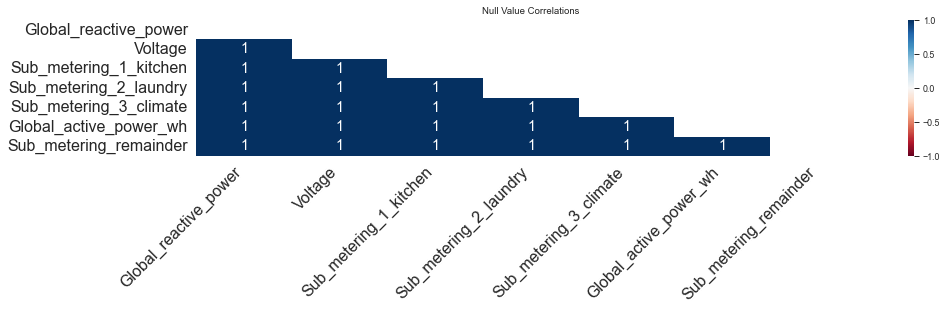

In [32]:
msno.heatmap(df_clean, figsize=(15, 2.5))
plt.title("Null Value Correlations")
plt.show()

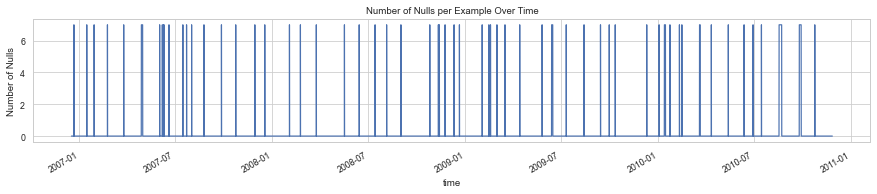

In [33]:
nulls_per_row = df_clean.set_index('time').isnull().sum(axis=1)
nulls_per_row.plot(figsize=(15, 2.5))
plt.ylabel("Number of Nulls")
plt.title("Number of Nulls per Example Over Time")
plt.show()

Notes:
* 1.25% of data is missing
* Missing data occurs simultaneously across all 8 features
* Missing data occurs consistently throughout the time-span of the dataset

## Univariate Analysis

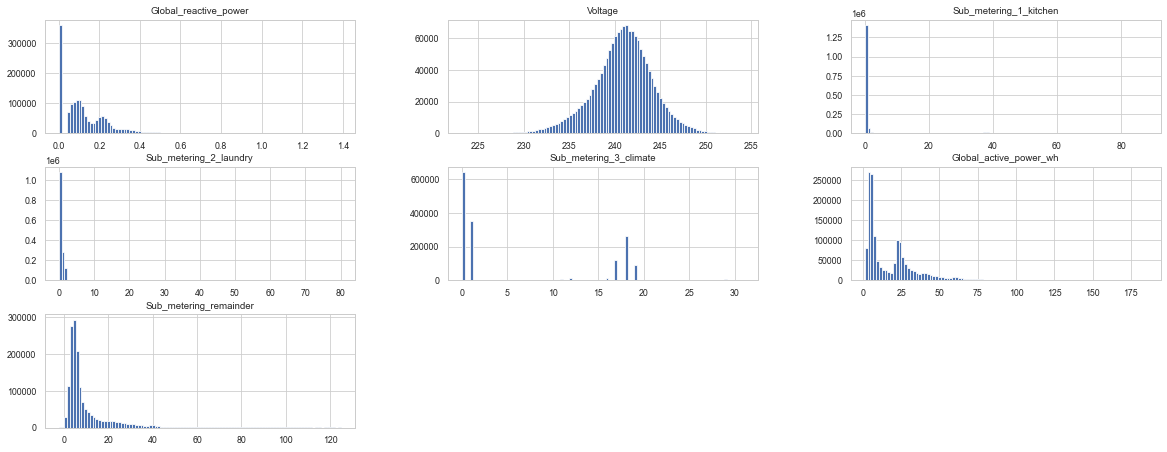

In [34]:
(df_clean
    .set_index('time')
    .hist(figsize=(20, 7.5), bins=100))
plt.show()

Notes:
* Global active power is bi-modal at the minute level
    * The household seems to have two distinct states of operating (e.g., day and night)
* Feature distributions are logarithmic
    * Exception of Voltage, which is normally distributed
    * Features may have to be normalized depending on how they are used downstream

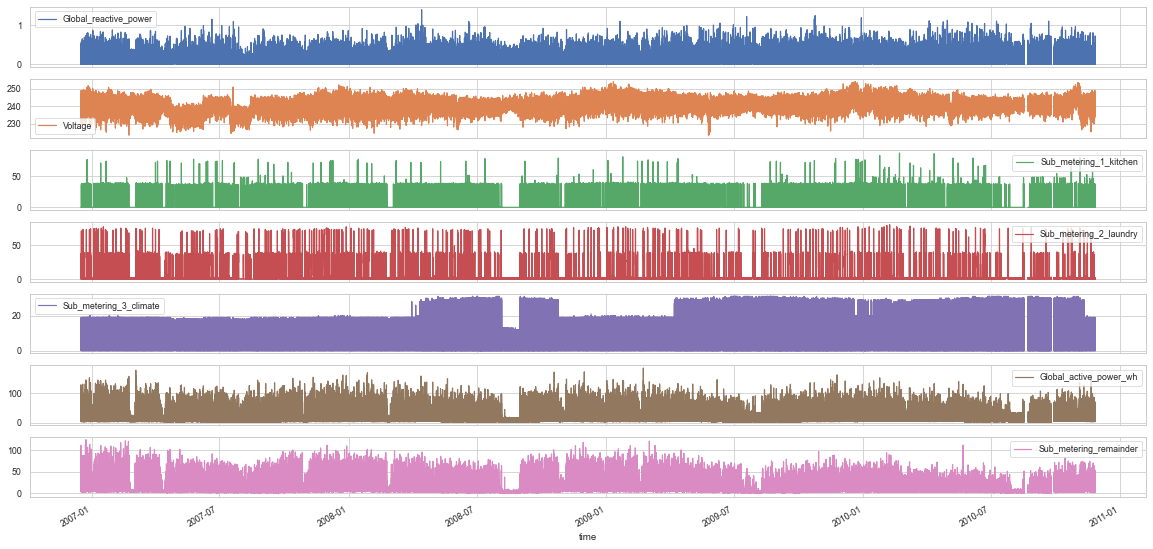

In [35]:
(df_clean
    .set_index('time')
    .plot(figsize=(20, 10), kind='line', subplots=True))
plt.show()

Notes:
* Unusual data pattern occurs ~August 2008
    * May be due to tenant absence
* Sub meter for climate control system has several distinctive uniform patterns over time
    * May be due to change of tenants and/or climate control systems

## Bivariate Analysis

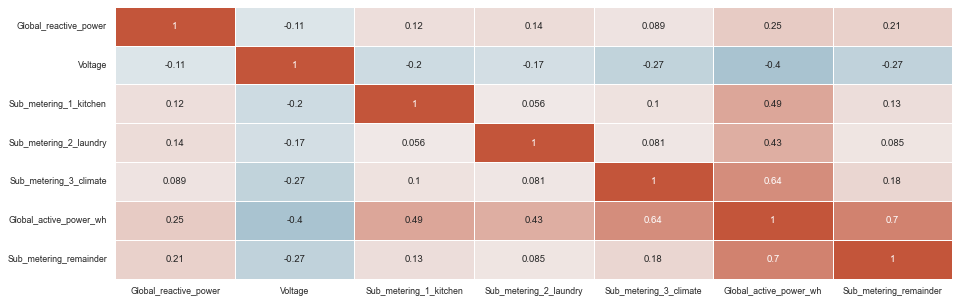

In [36]:
corr = df_clean.drop('time', axis=1).corr(method='pearson')

plt.figure(figsize=(15, 5))
sns.heatmap(
    corr,
    cmap=sns.diverging_palette(230, 20, as_cmap=True),
    vmax=1,
    center=0,
    square=False,
    linewidths=0.5,
    cbar_kws={"shrink": .5},
    annot=True,
    cbar=False)
plt.show()

Notes:
* As expected Voltage is negatively correlated with Global Active Power (ref: [Household Use of Electric Energy](http://hyperphysics.phy-astr.gsu.edu/hbase/electric/hsehld2.html))
* 49% of total energy consumption variation can be explained by remainder energy consumption

# Insights

## How is power consumpstion changing yearly?

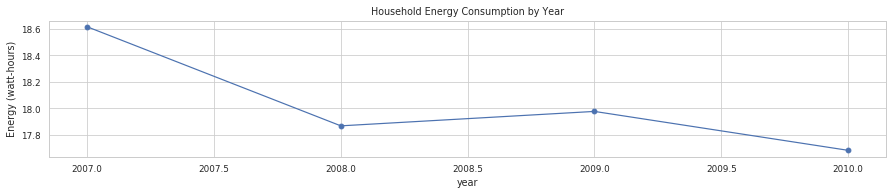

In [37]:
(df_clean
    .loc[df_clean.time.dt.year >= 2007]  # less than a month of data exists from 2006
    .assign(year=df_clean.time.dt.year)
    .set_index('year')
    .Global_active_power_wh
    .groupby('year')
    .mean()
    .plot(figsize=(15, 2.5), kind='line', style="-o"))
plt.ylabel("Energy (watt-hours)")
plt.title("Household Energy Consumption by Year")
plt.show()

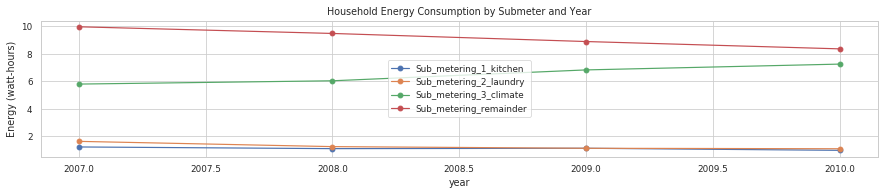

In [40]:
(df_clean
    .loc[df_clean.time.dt.year >= 2007]  # less than a month of data exists from 2006
    .assign(year=df_clean.time.dt.year)
    .set_index('year')
    .filter(like='Sub_metering')
    .groupby('year')
    .mean()
    .plot(figsize=(15, 2.5), kind='line', style="-o"))
plt.ylabel("Energy (watt-hours)")
plt.title("Household Energy Consumption by Submeter and Year")
plt.show()

Notes:
* Total energy usage decreased from 07 to 08, and then remained relatively stable
    * 07 to 08 decrease driven by decrease in Remainder energy usage
        * Remainder energy usage dips every August beginning in 08 (possibly due to vacation patterns)
* Climate energy usage increase year-over-year is approx. offset by remainder energy usage increase (08 to 10)
* Note: total energy usage decrease from 09 to 10 likely due to lack of data for 12-10

## What is the relationship between month and power consumption?

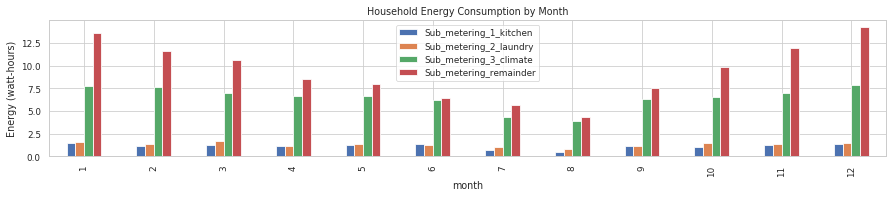

In [7]:
(df_clean
    .assign(month=df_clean.time.dt.month)
    .set_index('month')
    .filter(like='Sub_metering')
    .groupby('month')
    .mean()
    .plot(figsize=(15, 2.5), kind='bar', stacked=False))
plt.ylabel("Energy (watt-hours)")
plt.title("Household Energy Consumption by Month")
plt.show()

Notes:
* Remainder energy consumption has seasonal trend
    * Increases with colder weather
    * Possibly due to colder weather leading to tenants spending more time indoors using electricity
* Climate energy consumption has seasonal trend
    * Increases with colder weather
    * Possibly due to more energy needed to heat water in colder weather
* Kitchen and laundry energy consumption remain stable over seasons

## What is the relationship between day-of-the-week and power consumption?

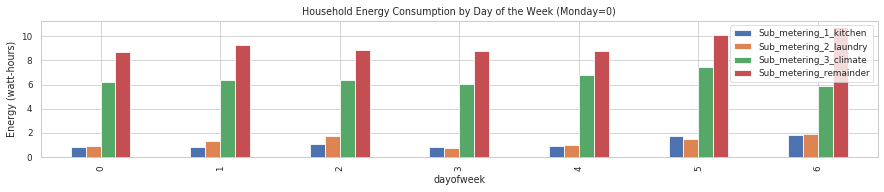

In [8]:
df_plot = (df_clean
    .assign(dayofweek=df_clean.time.dt.dayofweek)
    .set_index('dayofweek')
    .filter(like='Sub_metering')
    .groupby('dayofweek')
    .mean()
    .plot(figsize=(15, 2.5), kind='bar'))
plt.ylabel("Energy (watt-hours)")
plt.title("Household Energy Consumption by Day of the Week (Monday=0)")
plt.show()

Notes:
* Energy usage increases during weekends

## What is the relationship between hour-of-the-day and power consumption?

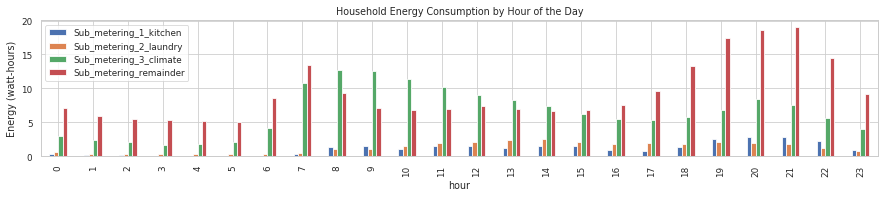

In [9]:
df_plot = (df_clean
    .assign(hour=df_clean.time.dt.hour)
    .set_index('hour')
    .filter(like='Sub_metering')
    .groupby('hour')
    .mean()
    .plot(figsize=(15, 2.5), kind='bar', stacked=False))
plt.ylabel("Energy (watt-hours)")
plt.title("Household Energy Consumption by Hour of the Day")
plt.show()

Notes:
* Remainder energy usage increases during evenings
* Remainder energy usage is a high contributor to overall energy throughout the night

In [56]:
# Sub metering remainder contains negative values
df_neg = df_clean[df_clean.Sub_metering_remainder < 0]
print("Number of negatives: {}".format(df_neg.shape[0]))
print("Sampe Example:")
df_neg.head(1)

Number of negatives: 1050
Sampe Example:


,time,Global_reactive_power,Voltage,Sub_metering_1_kitchen,Sub_metering_2_laundry,Sub_metering_3_climate,Global_active_power_wh,Sub_metering_remainder
176580,2007-04-18 08:24:00,0.0,236.25,33.0,0.0,17.0,49.866667,-0.133333


# Forecasting

In [18]:
# Create modelling dataset compatible with FB Prophet
df_model = (df_clean
    .loc[:, ['Global_active_power_wh', 'time']]
    .rename(columns={'Global_active_power_wh': 'y', 'time': 'ds'})  # neccessary for prophet
    .groupby(pd.Grouper(key='ds', freq="1D"))  # roll up to day level to speed up model training
    .mean()
    .reset_index())

df_model.head(2)

,ds,y
0,2006-12-16,50.891246
1,2006-12-17,39.241435


## Train Model

In [19]:
m = Prophet()
_ = m.fit(df_model)

In [21]:
# Save
with open('./models/serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [22]:
# Read
with open('./models/serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model
m.stan_backend = Prophet().stan_backend  # Instantiate stan backend for loaded model

## Inference

In [23]:
# Perform inference
future = m.make_future_dataframe(periods=365, freq='D')
pd_forecast = m.predict(future)

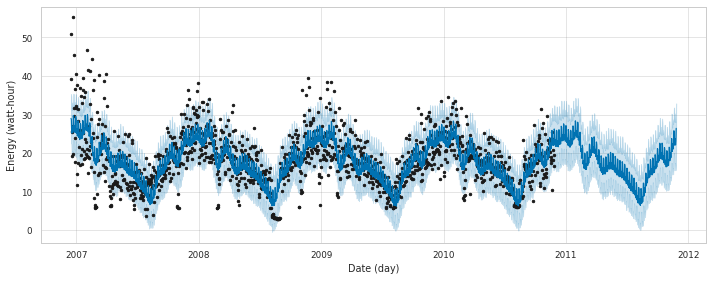

In [62]:
# Showcase forecast and historicals
_ = m.plot(pd_forecast, xlabel='Date (day)', ylabel='Energy (watt-hour)', figsize=(10, 4), uncertainty=True)

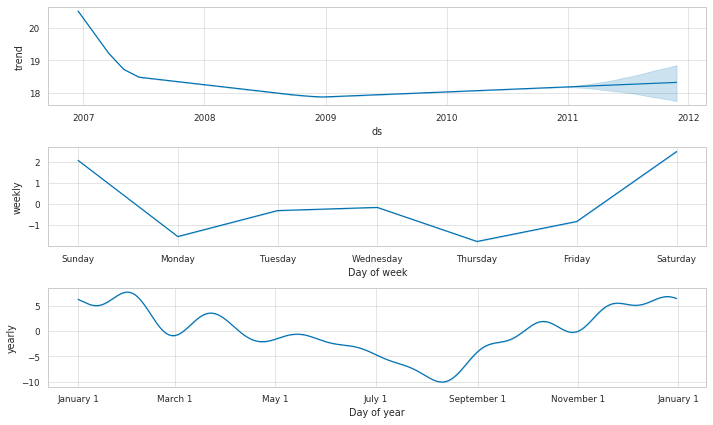

In [27]:
# Showcase model components
_ = m.plot_components(pd_forecast, figsize=(10, 6))

## Validation

In [76]:
# CV vaidate using 2010 data as test set
df_cv = cross_validation(
    m, 
    initial='1 days',
    cutoffs=[datetime.datetime(2010, 1, 1)],
    horizon='365 days')

In [108]:
df_cv['mape'] = abs(df_cv.y - df_cv.yhat) / df_cv.y * 100
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape
0,2010-01-02,26.985142,20.859877,33.514875,15.159092,2010-01-01,78.012917
1,2010-01-03,26.382717,20.072880,33.395402,24.114051,2010-01-01,9.408066
2,2010-01-04,21.792200,15.102855,28.517668,18.566343,2010-01-01,17.374762
3,2010-01-05,23.130401,16.802665,29.632575,25.691898,2010-01-01,9.970059
4,2010-01-06,22.981508,15.962282,29.400684,20.569213,2010-01-01,11.727698


In [103]:
overall_mape = abs(df_cv.y.sum() - df_cv.yhat.sum()) / df_cv.y.sum() * 100
print("Overa MAPE: {:.2f}%".format(overall_mape))

Overa MAPE: 4.72%


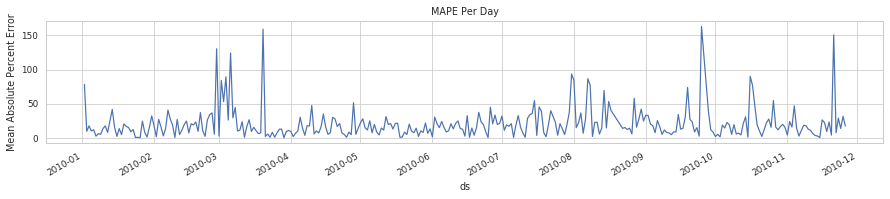

In [110]:
df_cv.set_index('ds').mape.plot(figsize=(15, 2.5))
plt.ylabel("Mean Absolute Percent Error")
plt.title("MAPE Per Day")
plt.show()

# Data Integrity Issues

# Future Work

* Improve robustness of performance metric used for model validation
* Optimize Prophet time-series modeling approach by tuning hyper-parameters
* Implement supervised ML model approach to forecasting

# References

* [How to Load and Explore Household Electricity Usage Data, Machine Learning Mastery, Json Browniee](https://machinelearningmastery.com/how-to-load-and-explore-household-electricity-usage-data/)